In [5]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score
import sys
import os

sys.path.append(os.path.abspath("../src"))
from triage.preprocess import clean_description

# Load data
X_train_combined = joblib.load("../models/X_train_combined.joblib")
X_test_combined = joblib.load("../models/X_test_combined.joblib")
y_train = joblib.load("../models/y_train.joblib")
y_test = joblib.load("../models/y_test.joblib")
vectorizer = joblib.load("../models/vectorizer.joblib")

print("Data loaded successfully!")
print(f"Training samples: {X_train_combined.shape[0]:,}")
print(f"Features: {X_train_combined.shape[1]:,}")
print(f"Classes: {y_train.nunique()}")

Data loaded successfully!
Training samples: 350,000
Features: 5,384
Classes: 10


## 1. Cross-Validation

Cross-validation provides a more robust estimate of model performance by:
- Training and testing on multiple data splits
- Reducing dependence on a single train/test split
- Detecting if model performance varies significantly across folds (sign of instability)

We'll use **5-fold stratified cross-validation** which:
- Splits data into 5 folds
- Maintains class distribution in each fold (important for imbalanced data)
- Trains on 4 folds, tests on 1 fold, rotates 5 times
- Reports mean and standard deviation of scores

CROSS-VALIDATION ANALYSIS

📊 Running 5-fold cross-validation...

✅ Cross-Validation Results:

Accuracy per fold: ['0.9212', '0.9192', '0.9195', '0.9195', '0.9207']
  Mean: 0.9200 ± 0.0008

F1-Macro per fold: ['0.9218', '0.9198', '0.9201', '0.9201', '0.9213']
  Mean: 0.9206 ± 0.0008

F1-Weighted per fold: ['0.9206', '0.9186', '0.9189', '0.9189', '0.9201']
  Mean: 0.9194 ± 0.0008

✅ Low variance across folds - model is stable!
✅ Cross-Validation Results:

Accuracy per fold: ['0.9212', '0.9192', '0.9195', '0.9195', '0.9207']
  Mean: 0.9200 ± 0.0008

F1-Macro per fold: ['0.9218', '0.9198', '0.9201', '0.9201', '0.9213']
  Mean: 0.9206 ± 0.0008

F1-Weighted per fold: ['0.9206', '0.9186', '0.9189', '0.9189', '0.9201']
  Mean: 0.9194 ± 0.0008

✅ Low variance across folds - model is stable!


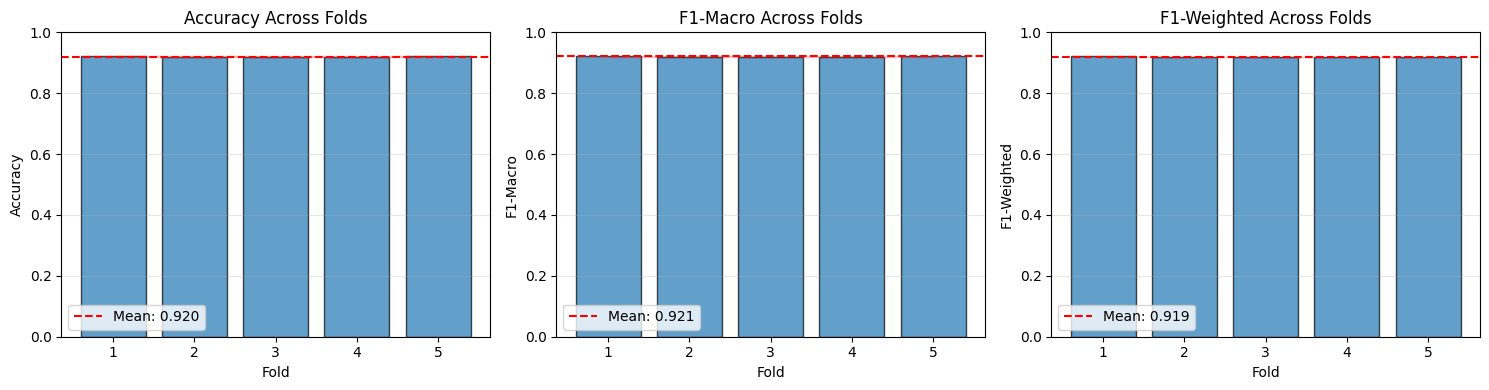

In [6]:
print("=" * 70)
print("CROSS-VALIDATION ANALYSIS")
print("=" * 70)

# Create base model (using your current configuration)
base_model = LogisticRegression(
    max_iter=6000,
    C=2.0,
    solver="saga",
    n_jobs=-1,
    class_weight="balanced",
    random_state=42,
)

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate with multiple metrics
print("\n📊 Running 5-fold cross-validation...\n")

# Accuracy scores
accuracy_scores = cross_val_score(
    base_model, X_train_combined, y_train, cv=cv, scoring="accuracy", n_jobs=-1
)

# F1 macro scores (better for imbalanced classes)
f1_scores = cross_val_score(
    base_model, X_train_combined, y_train, cv=cv, scoring="f1_macro", n_jobs=-1
)

# F1 weighted scores
f1_weighted_scores = cross_val_score(
    base_model, X_train_combined, y_train, cv=cv, scoring="f1_weighted", n_jobs=-1
)

print("✅ Cross-Validation Results:")
print(f"\nAccuracy per fold: {[f'{s:.4f}' for s in accuracy_scores]}")
print(f"  Mean: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")

print(f"\nF1-Macro per fold: {[f'{s:.4f}' for s in f1_scores]}")
print(f"  Mean: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

print(f"\nF1-Weighted per fold: {[f'{s:.4f}' for s in f1_weighted_scores]}")
print(f"  Mean: {f1_weighted_scores.mean():.4f} ± {f1_weighted_scores.std():.4f}")

# Interpretation
if accuracy_scores.std() < 0.01:
    print("\n✅ Low variance across folds - model is stable!")
else:
    print("\n⚠️ High variance across folds - model may be overfitting!")

# Visualize cross-validation scores
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, scores, title in zip(
    axes,
    [accuracy_scores, f1_scores, f1_weighted_scores],
    ["Accuracy", "F1-Macro", "F1-Weighted"],
):
    ax.bar(range(1, 6), scores, alpha=0.7, edgecolor="black")
    ax.axhline(scores.mean(), color="red", linestyle="--", label=f"Mean: {scores.mean():.3f}")
    ax.fill_between(
        range(1, 6),
        scores.mean() - scores.std(),
        scores.mean() + scores.std(),
        alpha=0.2,
        color="red",
    )
    ax.set_xlabel("Fold")
    ax.set_ylabel(title)
    ax.set_title(f"{title} Across Folds")
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Regularization Tuning (Grid Search)

The regularization parameter `C` controls the trade-off between:
- **High C (weak regularization)**: Model fits training data more closely → risk of overfitting
- **Low C (strong regularization)**: Model is simpler, more generalized → risk of underfitting

We'll use **GridSearchCV** to systematically test different C values and find the optimal one based on cross-validation performance.

**C values to test**: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
- Your current model uses C=2.0
- We'll see if a different value performs better

REGULARIZATION TUNING (GRID SEARCH)

🔍 Testing C values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
This may take a few minutes...

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ..............................................C=0.1; total time= 1.0min
[CV] END ..............................................C=0.1; total time= 1.0min
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ..............................................C=0.5; total time= 5.3min
[CV] END ..............................................C=0.5; total time= 5.3min
[CV] END ..............................................C=0.5; total time= 5.9min
[CV] END ..............................................C=0.5; total time= 5.9min
[CV] END 

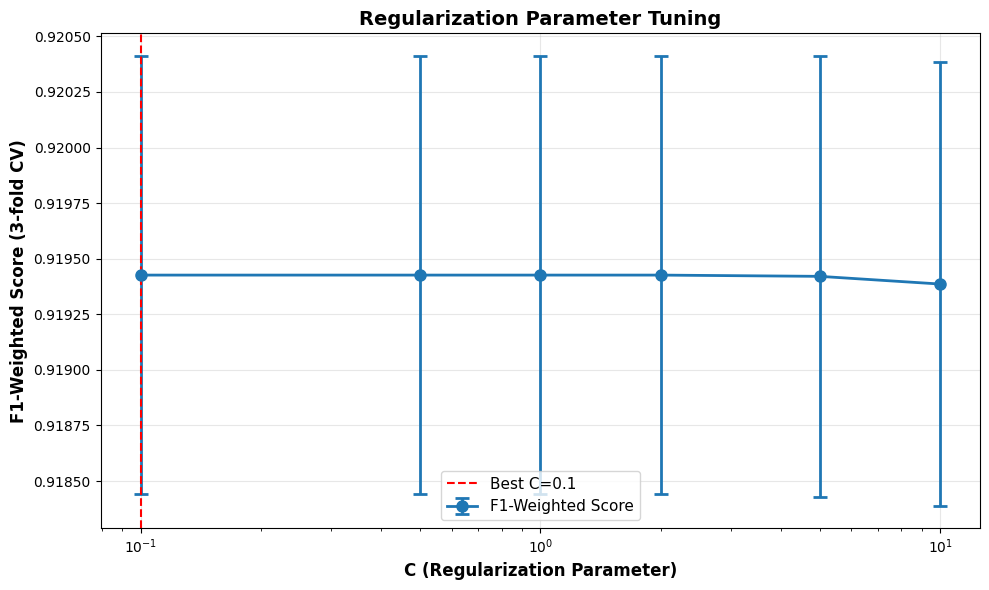


TEST SET PERFORMANCE (C=0.1)
                             precision    recall  f1-score   support

               access_abuse       0.92      0.89      0.90     15502
            benign_activity       0.92      0.88      0.90     15629
      credential_compromise       0.92      0.96      0.94     14427
          data_exfiltration       0.92      0.92      0.92     14994
             insider_threat       0.92      0.89      0.91     15658
                    malware       0.92      1.00      0.96     13797
                   phishing       0.92      1.00      0.96     13753
           policy_violation       0.92      0.85      0.88     16194
suspicious_network_activity       0.92      0.92      0.92     14982
                 web_attack       0.92      0.92      0.92     15064

                   accuracy                           0.92    150000
                  macro avg       0.92      0.92      0.92    150000
               weighted avg       0.92      0.92      0.92    150000

 

In [7]:
print("=" * 70)
print("REGULARIZATION TUNING (GRID SEARCH)")
print("=" * 70)

# Define parameter grid
param_grid = {
    "C": [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # Regularization strength
}

# Create base model
lr_model = LogisticRegression(
    max_iter=6000,
    solver="saga",
    n_jobs=-1,
    class_weight="balanced",
    random_state=42,
)

# Grid search with 3-fold CV (faster than 5-fold for large datasets)
grid_search = GridSearchCV(
    lr_model,
    param_grid,
    cv=3,
    scoring="f1_weighted",  # Optimize for weighted F1 (handles class imbalance)
    n_jobs=-1,
    verbose=2,
)

print("\n🔍 Testing C values:", param_grid["C"])
print("This may take a few minutes...\n")

# Fit grid search
grid_search.fit(X_train_combined, y_train)

print("\n" + "=" * 70)
print("GRID SEARCH RESULTS")
print("=" * 70)

# Best parameters
print(f"\n🏆 Best C value: {grid_search.best_params_['C']}")
print(f"🏆 Best CV F1-Weighted score: {grid_search.best_score_:.4f}")

# Show all results
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[["param_C", "mean_test_score", "std_test_score", "rank_test_score"]]
results_df = results_df.sort_values("rank_test_score")

print("\n📊 All C values tested (ranked):")
print(results_df.to_string(index=False))

# Compare with current model (C=2.0)
current_c_score = results_df[results_df["param_C"] == 2.0]["mean_test_score"].values[0]
improvement = grid_search.best_score_ - current_c_score

if grid_search.best_params_["C"] == 2.0:
    print("\n✅ Your current C=2.0 is already optimal!")
else:
    print(f"\n💡 Switching from C=2.0 to C={grid_search.best_params_['C']} would improve F1 by {improvement:.4f}")

# Visualize C parameter performance
plt.figure(figsize=(10, 6))
c_values = results_df["param_C"].values
scores = results_df["mean_test_score"].values
stds = results_df["std_test_score"].values

plt.errorbar(c_values, scores, yerr=stds, marker="o", markersize=8, 
             capsize=5, capthick=2, linewidth=2, label="F1-Weighted Score")
plt.axvline(grid_search.best_params_["C"], color="red", linestyle="--", 
            label=f"Best C={grid_search.best_params_['C']}")
plt.xlabel("C (Regularization Parameter)", fontsize=12, fontweight="bold")
plt.ylabel("F1-Weighted Score (3-fold CV)", fontsize=12, fontweight="bold")
plt.title("Regularization Parameter Tuning", fontsize=14, fontweight="bold")
plt.xscale("log")  # Log scale for C
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Train final model with best C
best_model = LogisticRegression(
    max_iter=6000,
    C=grid_search.best_params_["C"],
    solver="saga",
    n_jobs=-1,
    class_weight="balanced",
    random_state=42,
)

best_model.fit(X_train_combined, y_train)
test_predictions = best_model.predict(X_test_combined)

print("\n" + "=" * 70)
print(f"TEST SET PERFORMANCE (C={grid_search.best_params_['C']})")
print("=" * 70)
print(classification_report(y_test, test_predictions))

## 3. Data Augmentation

Data augmentation creates additional training examples by applying transformations that preserve the label but increase diversity. For text data:

**Techniques:**
1. **Synonym replacement**: Replace words with synonyms
2. **Back-translation**: Translate to another language and back
3. **Contextual word embeddings**: Use language models to generate paraphrases
4. **Random insertion/deletion**: Add/remove random words

**Simple approach for your use case:**
- Generate more synthetic incidents using your existing generator
- Vary the templates and parameters more
- Add more edge cases and ambiguous examples

Let's implement a simple text augmentation approach:

In [8]:
import random
from scipy.sparse import vstack

print("=" * 70)
print("DATA AUGMENTATION EXAMPLES")
print("=" * 70)

# Synonym dictionary for common cybersecurity terms
SYNONYMS = {
    "detected": ["identified", "found", "discovered", "observed", "spotted"],
    "suspicious": ["anomalous", "unusual", "questionable", "concerning", "irregular"],
    "alert": ["notification", "warning", "alarm", "signal"],
    "user": ["employee", "account", "individual", "person"],
    "attempted": ["tried", "initiated", "executed"],
    "malicious": ["harmful", "dangerous", "threatening", "hostile"],
    "activity": ["behavior", "action", "event", "operation"],
    "unauthorized": ["unapproved", "illegitimate", "forbidden"],
    "attack": ["exploit", "assault", "intrusion", "breach attempt"],
    "compromised": ["breached", "infected", "penetrated", "violated"],
}


def augment_text_synonyms(text, num_replacements=2):
    """Replace random words with synonyms."""
    words = text.split()
    replaced = 0
    
    for i, word in enumerate(words):
        word_lower = word.lower().strip(".,!?;:")
        if word_lower in SYNONYMS and random.random() < 0.3 and replaced < num_replacements:
            synonym = random.choice(SYNONYMS[word_lower])
            # Preserve capitalization
            if word[0].isupper():
                synonym = synonym.capitalize()
            words[i] = synonym + word[len(word_lower):]  # Keep punctuation
            replaced += 1
    
    return " ".join(words)


def augment_text_reorder(text):
    """Reorder sentences while preserving meaning."""
    sentences = text.split(". ")
    if len(sentences) > 1:
        random.shuffle(sentences)
        return ". ".join(sentences)
    return text


# Example augmentations
example_text = "Security alert detected suspicious activity from user account. Unauthorized login attempted from foreign IP address."

print("\n📝 Original Text:")
print(f"  {example_text}")

print("\n🔄 Augmented Versions:")
for i in range(3):
    augmented = augment_text_synonyms(example_text, num_replacements=2)
    print(f"  {i+1}. {augmented}")

print("\n💡 How to use augmentation:")
print("  1. For minority classes with few examples")
print("  2. To double/triple your training data size")
print("  3. Apply during training (online augmentation)")
print("  4. Or pre-generate augmented dataset (offline)")

DATA AUGMENTATION EXAMPLES

📝 Original Text:
  Security alert detected suspicious activity from user account. Unauthorized login attempted from foreign IP address.

🔄 Augmented Versions:
  1. Security signal detected suspicious activity from user account. Unauthorized login attempted from foreign IP address.
  2. Security alert detected suspicious action from user account. Illegitimate login attempted from foreign IP address.
  3. Security alarm detected suspicious activity from user account. Forbidden login attempted from foreign IP address.

💡 How to use augmentation:
  1. For minority classes with few examples
  2. To double/triple your training data size
  3. Apply during training (online augmentation)
  4. Or pre-generate augmented dataset (offline)


## 4. Recommended Approach: Generate More Diverse Data

**Best strategy for your project**: Improve your data generator to create more diverse examples.

### Action Items:

1. **Increase dataset size**:
   ```bash
   # Generate 300k-500k examples instead of 200k
   python generator/generate_cyber_incidents.py --count 300000
   ```

2. **Add more template variations**:
   - More phishing email templates
   - More malware behavior descriptions
   - More edge cases between classes

3. **Create harder examples**:
   - Borderline cases (phishing vs benign)
   - Mixed scenarios (data exfiltration + credential compromise)
   - Subtle variations that test model understanding

4. **Balance class distribution better**:
   - Ensure minority classes have enough examples
   - Add more variation within each class

5. **Keep the noise!**:
   - 8% label noise is good (mimics real annotation errors)
   - Typos help with real-world robustness
   - These prevent overfitting, not cause it

## Summary & Recommendations

### What You Learned:

✅ **Cross-Validation**: Your model should have low variance (< 1% std) across folds
- If variance is high → model is unstable/overfitting
- If variance is low → model is robust

✅ **Regularization**: Optimal C parameter balances fit vs generalization
- Too high C → overfitting
- Too low C → underfitting
- Use grid search to find best value

✅ **Data Augmentation**: More diverse examples = better generalization
- Synonym replacement
- Better: generate more synthetic data

### Next Steps:

1. **Run cross-validation** to check if your current model is stable
2. **Run grid search** to optimize C parameter
3. **Generate more diverse training data** (300k-500k examples)
4. **Keep the label noise and typos** - they help, not hurt!
5. **Monitor test set performance** - if it's much worse than train, you're overfitting

### Signs of Overfitting:
- High training accuracy (>95%) but low test accuracy (<85%)
- High variance in cross-validation scores
- Model fails on slight variations of known examples

### Signs of Underfitting:
- Both training and test accuracy are low (<80%)
- Model makes obvious mistakes
- Increasing C improves performance

Your model at ~85-90% test accuracy is likely in a good spot!